In [1]:
# !pip install diffusers

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from diffusers import UNet2DModel, DDPMScheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm

from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"
use_inter_annual = True

class ClimateDataset(Dataset):
    def __init__(self, images, conds):
        self.images = images
        self.conds = conds

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.conds[idx]

class DeterministicNN(nn.Module):
    """Simple NN that learns the mean temperature field from emissions"""
    def __init__(self, n_cond=2, spatial_size=(96, 144)):
        super().__init__()
        self.H, self.W = spatial_size
        output_size = self.H * self.W
        self.net = nn.Sequential(
            nn.Linear(n_cond, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )
        
    def forward(self, cond, H, W):
        """
        cond: (B, 2) - CO2, CH4
        Returns: (B, 1, H, W) - predicted mean temperature field
        """
        B = cond.shape[0]
        x = self.net(cond)  # (B, H*W)
        x = x.view(B, 1, H, W)
        return x


class ResidualDiffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = UNet2DModel(
            sample_size=(96, 144),
            in_channels=3, 
            out_channels=2,  
            layers_per_block=2,
            block_out_channels=(32, 64, 128),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
        )
    
    def forward(self, noisy_residual, mean_pred, timestep):
        """
        noisy_residual: (B, 2, H, W) - noisy version of [residual, velocity]
        mean_pred: (B, 1, H, W) - deterministic prediction (conditioning)
        timestep: (B,) - diffusion timestep
        """
        x = torch.cat([noisy_residual, mean_pred], dim=1)  # (B, 3, H, W)
        return self.unet(x, timestep).sample


In [14]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"
train_files = ["historical", "ssp585", "ssp126", "ssp370", "hist-GHG", "hist-aer"]

X_train_xr, _ = prepare_predictor(train_files, train_path)
y_train_xr, _ = prepare_predictand(train_files, train_path)
X_test_xr, _  = prepare_predictor('ssp245', data_path=test_path, time_reindex=False)
y_test_xr, _  = prepare_predictand('ssp245', data_path=test_path, time_reindex=False)

y_baseline_xr, _  = prepare_predictand(["historical"], train_path)
y_baseline_xr = y_baseline_xr.mean('time').copy()

# calc anomalies
y_train_xr["tas"].values = (y_train_xr["tas"] - y_baseline_xr["tas"]).values
y_test_xr["tas"].values = (y_test_xr["tas"] - y_baseline_xr["tas"]).values

# to pandas
X_train_df = pd.DataFrame({
    "CO2": X_train_xr["CO2"].data,
    "CH4": X_train_xr["CH4"].data
}, index=X_train_xr["CO2"].coords['time'].data)

X_test_df = pd.DataFrame({
    "CO2": X_test_xr["CO2"].data,
    "CH4": X_test_xr["CH4"].data
}, index=X_test_xr["CO2"].coords['time'].data)

# Standardize
mean, std = X_train_df.mean(), X_train_df.std()
X_train_df = (X_train_df - mean) / std
X_test_df  = (X_test_df - mean) / std

# Flatten 
y_train_df = y_train_xr["tas"].stack({"stacked": ("latitude", "longitude")})
y_train_df = pd.DataFrame(y_train_df.to_pandas())

y_test_df = y_test_xr["tas"].stack({"stacked": ("latitude", "longitude")})
y_test_df = pd.DataFrame(y_test_df.to_pandas())

# To tensors
X_train_tensor = torch.tensor(X_train_df.to_numpy(), dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_df.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_xr["tas"].values, dtype=torch.float32).unsqueeze(1)
y_test_tensor  = torch.tensor(y_test_xr["tas"].values, dtype=torch.float32).unsqueeze(1)

# Split
train_size = int(0.8 * len(y_train_tensor))
train_dataset = ClimateDataset(y_train_tensor[:train_size], X_train_tensor[:train_size])
val_dataset   = ClimateDataset(y_train_tensor[train_size:], X_train_tensor[train_size:])
test_dataset  = ClimateDataset(y_test_tensor, X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False) # so we can use interannual variability
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
H, W = y_train_tensor.shape[2], y_train_tensor.shape[3]
det_model = DeterministicNN(spatial_size=(H, W)).to(device)
det_optimizer = torch.optim.Adam(det_model.parameters(), lr=1e-3)

for epoch in range(100):
    # Training
    det_model.train()
    total_train_loss = 0
    for imgs, conds in train_loader:
        imgs, conds = imgs.to(device), conds.to(device)
        B, _, H, W = imgs.shape
        
        pred = det_model(conds, H, W)
        loss = torch.nn.functional.mse_loss(pred, imgs)
        
        det_optimizer.zero_grad()
        loss.backward()
        det_optimizer.step()
        total_train_loss += loss.item() * B
    
    # Validation
    det_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, conds in val_loader:
            imgs, conds = imgs.to(device), conds.to(device)
            B, _, H, W = imgs.shape
            pred = det_model(conds, H, W)
            loss = torch.nn.functional.mse_loss(pred, imgs)
            total_val_loss += loss.item() * B
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {total_train_loss/len(train_dataset):.6f} | "
          f"Val Loss: {total_val_loss/len(val_dataset):.6f}")

Epoch 01 | Train Loss: 2.486841 | Val Loss: 0.665281
Epoch 02 | Train Loss: 0.810538 | Val Loss: 0.662983
Epoch 03 | Train Loss: 1.109617 | Val Loss: 0.592343
Epoch 04 | Train Loss: 1.405565 | Val Loss: 0.525707
Epoch 05 | Train Loss: 1.668063 | Val Loss: 0.587028
Epoch 06 | Train Loss: 1.727629 | Val Loss: 0.573309
Epoch 07 | Train Loss: 0.717643 | Val Loss: 0.575310
Epoch 08 | Train Loss: 0.470854 | Val Loss: 0.566729
Epoch 09 | Train Loss: 0.342320 | Val Loss: 0.538571
Epoch 10 | Train Loss: 0.337481 | Val Loss: 0.544925
Epoch 11 | Train Loss: 0.338671 | Val Loss: 0.539573
Epoch 12 | Train Loss: 0.337854 | Val Loss: 0.538778
Epoch 13 | Train Loss: 0.337468 | Val Loss: 0.536196
Epoch 14 | Train Loss: 0.336385 | Val Loss: 0.535000
Epoch 15 | Train Loss: 0.335518 | Val Loss: 0.533923
Epoch 16 | Train Loss: 0.334637 | Val Loss: 0.530680
Epoch 17 | Train Loss: 0.333887 | Val Loss: 0.528317
Epoch 18 | Train Loss: 0.333385 | Val Loss: 0.525409
Epoch 19 | Train Loss: 0.332960 | Val Loss: 0.

In [16]:
diff_model = ResidualDiffusion().to(device)
scheduler = DDPMScheduler(num_train_timesteps=50, beta_start=1e-4, beta_end=0.02)
diff_optimizer = torch.optim.Adam(diff_model.parameters(), lr=1e-4)


for epoch in range(10):
    # Training
    diff_model.train()
    det_model.eval()
    total_train_loss = 0
    
    for imgs, conds in train_loader:
        imgs, conds = imgs.to(device), conds.to(device)
        B, C, H, W = imgs.shape
        
        with torch.no_grad():
            mean_pred = det_model(conds, H, W)
        
        residual = imgs - mean_pred
        
        if use_inter_annual:
            residual_diff = residual[1:] - residual[:-1]
            target = residual[1:]
            target_velocity = residual_diff
            target_combined = torch.cat([target, target_velocity], dim=1)
            mean_pred_aligned = mean_pred[1:]
            effective_batch = B - 1
        else:
            # Create 2-channel target: residual + zero velocity
            target_combined = torch.cat([residual, torch.zeros_like(residual)], dim=1)
            mean_pred_aligned = mean_pred
            effective_batch = B
        
        t = torch.randint(0, scheduler.config.num_train_timesteps, (effective_batch,), device=device).long()
        noise = torch.randn_like(target_combined)
        noisy_target = scheduler.add_noise(target_combined, noise, t)
        
        noise_pred = diff_model(noisy_target, mean_pred_aligned, t)
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        
        diff_optimizer.zero_grad()
        loss.backward()
        diff_optimizer.step()
        total_train_loss += loss.item() * effective_batch
    
    # Validation
    diff_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, conds in val_loader:
            imgs, conds = imgs.to(device), conds.to(device)
            B, C, H, W = imgs.shape
            
            mean_pred = det_model(conds, H, W)
            residual = imgs - mean_pred
            
            if use_inter_annual:
                residual_diff = residual[1:] - residual[:-1]
                target = residual[1:]
                target_velocity = residual_diff
                target_combined = torch.cat([target, target_velocity], dim=1)
                mean_pred_aligned = mean_pred[1:]
                effective_batch = B - 1
            else:
                # Create 2-channel target: residual + zero velocity
                target_combined = torch.cat([residual, torch.zeros_like(residual)], dim=1)
                mean_pred_aligned = mean_pred
                effective_batch = B
            
            t = torch.randint(0, scheduler.config.num_train_timesteps, (effective_batch,), device=device).long()
            noise = torch.randn_like(target_combined)
            noisy_target = scheduler.add_noise(target_combined, noise, t)
            
            noise_pred = diff_model(noisy_target, mean_pred_aligned, t)
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            total_val_loss += loss.item() * effective_batch
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {total_train_loss/len(train_dataset):.6f} | "
          f"Val Loss: {total_val_loss/len(val_dataset):.6f}")

Epoch 01 | Train Loss: 0.695697 | Val Loss: 0.442996
Epoch 02 | Train Loss: 0.356555 | Val Loss: 0.240456
Epoch 03 | Train Loss: 0.278700 | Val Loss: 0.216495
Epoch 04 | Train Loss: 0.241816 | Val Loss: 0.197800
Epoch 05 | Train Loss: 0.228344 | Val Loss: 0.194660
Epoch 06 | Train Loss: 0.215078 | Val Loss: 0.185814
Epoch 07 | Train Loss: 0.213676 | Val Loss: 0.173620
Epoch 08 | Train Loss: 0.200762 | Val Loss: 0.189076
Epoch 09 | Train Loss: 0.191292 | Val Loss: 0.159753
Epoch 10 | Train Loss: 0.169789 | Val Loss: 0.174843


In [17]:
det_model.eval()
diff_model.eval()

B_test = X_test_tensor.shape[0]
H, W = y_test_tensor.shape[2], y_test_tensor.shape[3]
n_ensemble = 10

print("Computing deterministic mean fields...")
det_predictions = []
with torch.no_grad():
    for idx in tqdm(range(B_test), desc="Deterministic Prediction"):
        cond = X_test_tensor[idx:idx+1].to(device)
        mean_pred = det_model(cond, H, W)
        det_predictions.append(mean_pred.cpu())
det_predictions = torch.cat(det_predictions, dim=0)  # (B_test, 1, H, W)

# Setup the scheduler for inference
scheduler.set_timesteps(50, device=device)
scheduler.timesteps = scheduler.timesteps.to(device)

ensemble_predictions = torch.zeros(n_ensemble, B_test, H, W, device='cpu')

print("Generating ensemble members...")
for ens_idx in tqdm(range(n_ensemble), desc="Ensemble Members"):
    if use_inter_annual:
        residual = torch.randn(B_test, 2, H, W, device=device)
    else:
        residual = torch.cat([
            torch.randn(B_test, 1, H, W, device=device),
            torch.zeros(B_test, 1, H, W, device=device)
        ], dim=1)
    mean_exp = det_predictions.to(device)
    
    for t_step in reversed(scheduler.timesteps):
        # Pass t_step directly as scalar, not t_tensor
        with torch.no_grad():
            noise_pred = diff_model(residual, mean_exp, t_step)
            residual = scheduler.step(noise_pred, t_step, residual).prev_sample
    
    final_pred = mean_exp + residual[:, :1, :, :]
    ensemble_predictions[ens_idx] = final_pred.squeeze(1).cpu()

ensemble_mean = ensemble_predictions.mean(dim=0)
ensemble_std = ensemble_predictions.std(dim=0)

Computing deterministic mean fields...


Deterministic Prediction:   0%|          | 0/86 [00:00<?, ?it/s]

Generating ensemble members...


Ensemble Members:   0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
# setup for plots
baseline_tensor = torch.tensor(y_baseline_xr["tas"].values, dtype=torch.float32)

# Create xarray objects for plotting
det_xr = y_test_xr["tas"].copy()
det_xr.values = baseline_tensor.numpy() + det_predictions.squeeze(1).numpy()  # ← Add .squeeze(1)

ensemble_mean_xr = y_test_xr["tas"].copy()
ensemble_mean_xr.values = baseline_tensor.numpy() + ensemble_mean.numpy()

ensemble_std_xr = y_test_xr["tas"].copy()
ensemble_std_xr.values = ensemble_std.numpy()

truth_xr = y_test_xr["tas"].copy()
truth_xr.values = y_test_tensor.squeeze(1).numpy() + baseline_tensor.numpy()

# imdvl ensemble members for viz
ensemble_members_xr = []
for i in range(n_ensemble):
    member_xr = y_test_xr["tas"].copy()
    member_xr.values = baseline_tensor.numpy() + ensemble_predictions[i].numpy()
    ensemble_members_xr.append(member_xr)

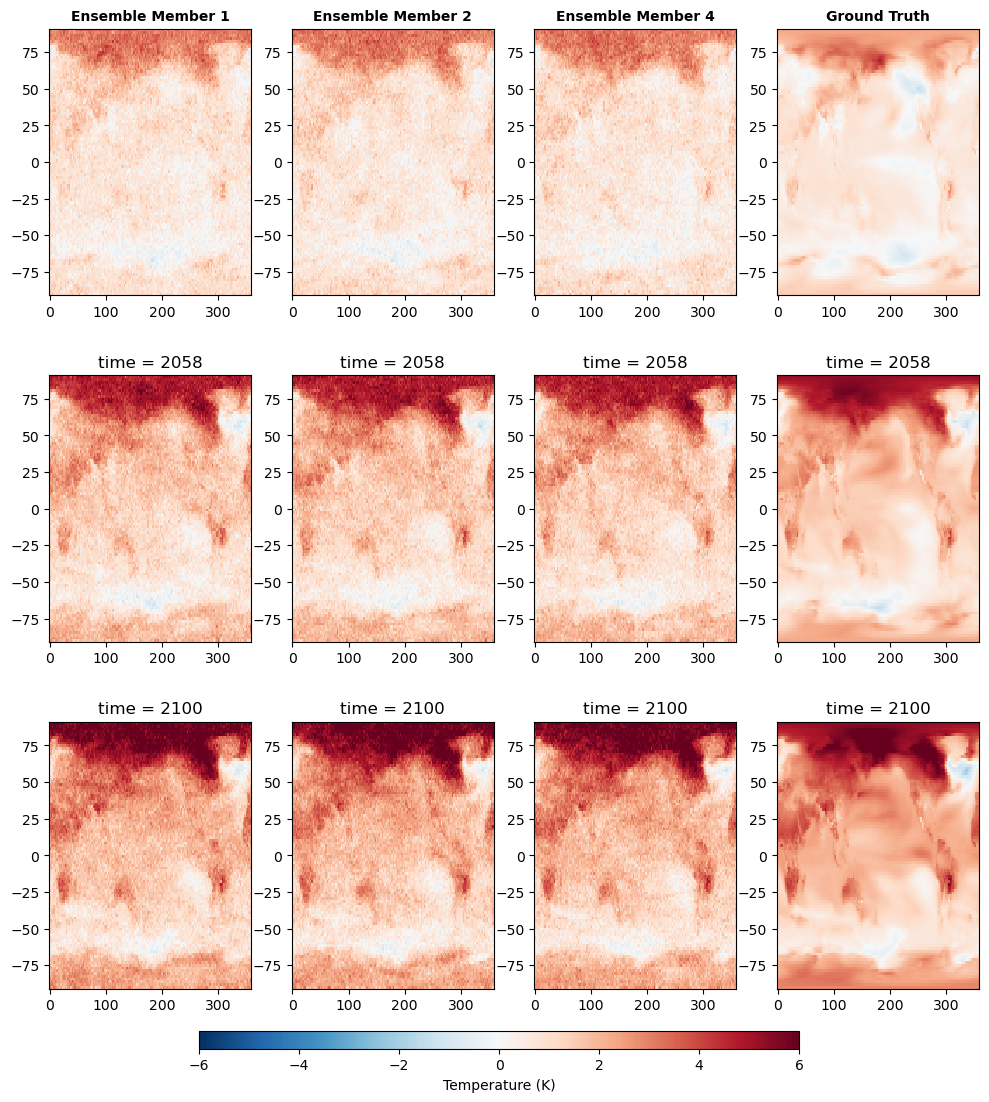

In [19]:
n_samples = y_test_tensor.shape[0]
sample_idxs = [0, n_samples // 2, -1]

# Select x ensemble members to visualize
plot_members = [0, 1, 3] 

vmin, vmax = -6, 6
cmap = 'RdBu_r'

fig1, axes = plt.subplots(figsize=(12, 12), nrows=3, ncols=len(plot_members)+1)

for i, idx in enumerate(sample_idxs):
    yr = truth_xr.isel(time=idx).time.item()
    
    #  selected ensemble members
    for j, m in enumerate(plot_members):
        im = ensemble_members_xr[m].isel(time=idx).plot(
            ax=axes[i, j], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
        )
        if i == 0:
            axes[i, j].set_title(f'Ensemble Member {m+1}', fontweight='bold', fontsize=10)
        axes[i, j].set_xlabel("")
        axes[i, j].set_ylabel("")
    
    # grnd truth in the last column
    truth_xr.isel(time=idx).plot(
        ax=axes[i, -1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
    )
    if i == 0:
        axes[i, -1].set_title('Ground Truth', fontweight='bold', fontsize=10)
    axes[i, -1].set_xlabel("")
    axes[i, -1].set_ylabel("")

plt.subplots_adjust(hspace=0.3, wspace=0.2, bottom=0.08)
cbar_ax = fig1.add_axes([0.25, 0.03, 0.5, 0.015])
fig1.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Temperature (K)')
plt.show()

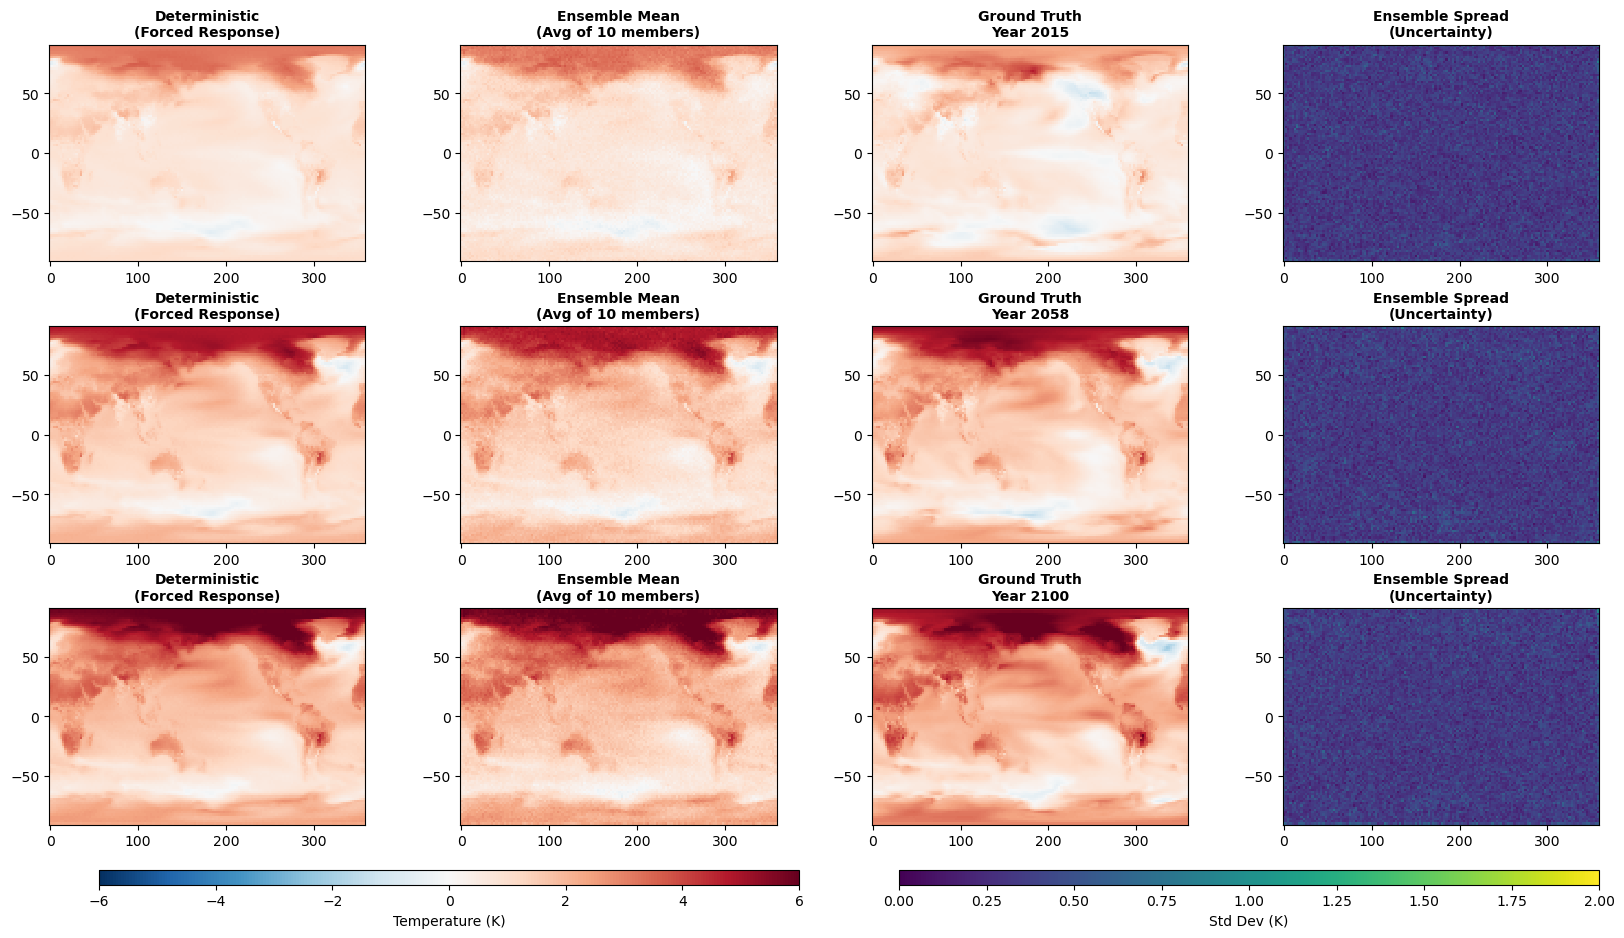

In [20]:
fig2, axes = plt.subplots(figsize=(20, 10), nrows=3, ncols=4)
vmin_temp, vmax_temp = -6, 6
vmin_std, vmax_std = 0, 2

for i, idx in enumerate(sample_idxs):
    yr = truth_xr.isel(time=idx).time.item()
    
    im1 = det_xr.isel(time=idx).plot(
        ax=axes[i, 0], cmap=cmap, vmin=vmin_temp, vmax=vmax_temp, add_colorbar=False
    )
    axes[i, 0].set_title(f'Deterministic\n(Forced Response)', fontweight='bold', fontsize=10)
    
    ensemble_mean_xr.isel(time=idx).plot(
        ax=axes[i, 1], cmap=cmap, vmin=vmin_temp, vmax=vmax_temp, add_colorbar=False
    )
    axes[i, 1].set_title(f'Ensemble Mean\n(Avg of {n_ensemble} members)', fontweight='bold', fontsize=10)

    truth_xr.isel(time=idx).plot(
        ax=axes[i, 2], cmap=cmap, vmin=vmin_temp, vmax=vmax_temp, add_colorbar=False
    )
    axes[i, 2].set_title(f'Ground Truth\nYear {yr}', fontweight='bold', fontsize=10)

    im2 = ensemble_std_xr.isel(time=idx).plot(
        ax=axes[i, 3], cmap='viridis', vmin=vmin_std, vmax=vmax_std, add_colorbar=False
    )
    axes[i, 3].set_title(f'Ensemble Spread\n(Uncertainty)', fontweight='bold', fontsize=10)
    
    for ax in axes[i, :]:
        ax.set_xlabel("")
        ax.set_ylabel("")

plt.subplots_adjust(hspace=0.3, wspace=0.3, bottom=0.1)

# Add colorbars
cbar_ax1 = fig2.add_axes([0.15, 0.04, 0.35, 0.015])
fig2.colorbar(im1, cax=cbar_ax1, orientation='horizontal', label='Temperature (K)')

cbar_ax2 = fig2.add_axes([0.55, 0.04, 0.35, 0.015])
fig2.colorbar(im2, cax=cbar_ax2, orientation='horizontal', label='Std Dev (K)')

plt.show()

/tmp/ipykernel_4384/583178185.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  det_global = global_mean(det_predictions + baseline_tensor.numpy())
/tmp/ipykernel_4384/583178185.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ensemble_global = [global_mean(ensemble_predictions[i] + baseline_tensor.numpy())
/tmp/ipykernel_4384/583178185.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ensemble_mean_global = global_mean(ensemble_mean + baseline_tensor.numpy())


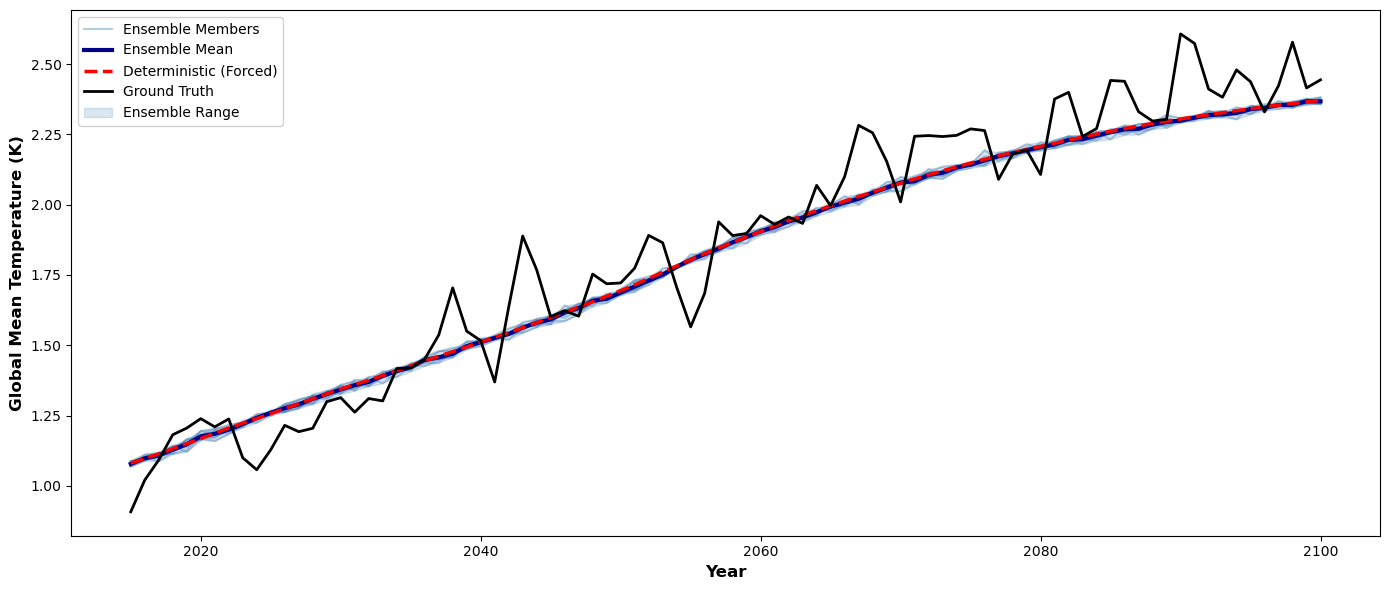

In [21]:
def global_mean(data):
    """Compute global mean accounting for latitude weighting"""
    return data.mean(axis=(-2, -1))

# Compute global means
years = y_test_xr.time.values
truth_global = global_mean(y_test_tensor.squeeze(1).numpy() + baseline_tensor.numpy())
det_global = global_mean(det_predictions + baseline_tensor.numpy())
ensemble_global = [global_mean(ensemble_predictions[i] + baseline_tensor.numpy()) 
                   for i in range(n_ensemble)]
ensemble_mean_global = global_mean(ensemble_mean + baseline_tensor.numpy())

fig3, ax = plt.subplots(figsize=(14, 6))

# Plot ensemble members (thin lines)
for i, member_global in enumerate(ensemble_global):
    ax.plot(years, member_global, alpha=0.4, linewidth=1.5, color='steelblue',
            label='Ensemble Members' if i == 0 else '')

# Plot ensemble mean (thick line)
ax.plot(years, ensemble_mean_global, color='darkblue', linewidth=3, 
        label='Ensemble Mean', zorder=10)

# Plot deterministic (forced response)
ax.plot(years, det_global, color='red', linewidth=2.5, linestyle='--',
        label='Deterministic (Forced)', zorder=11)

# Plot truth
ax.plot(years, truth_global, color='black', linewidth=2, 
        label='Ground Truth', zorder=12)

# Shading for ensemble spread
ensemble_min = np.min(ensemble_global, axis=0)
ensemble_max = np.max(ensemble_global, axis=0)
ax.fill_between(years, ensemble_min, ensemble_max, alpha=0.2, color='steelblue',
                label='Ensemble Range')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Global Mean Temperature (K)', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.tight_layout()

In [22]:
# Compute metrics
det_mae = np.abs(det_predictions - y_test_tensor.squeeze(1).numpy()).mean()
ensemble_mean_mae = np.abs(ensemble_mean - y_test_tensor.squeeze(1).numpy()).mean()

print(f"Test MAE - Deterministic (Forced Response): {det_mae:.4f} K")
print(f"Test MAE - Ensemble Mean: {ensemble_mean_mae:.4f} K")
print(f"Ensemble Spread (avg std): {ensemble_std.mean():.4f} K")


Test MAE - Deterministic (Forced Response): 0.6017 K
Test MAE - Ensemble Mean: 0.3207 K
Ensemble Spread (avg std): 0.3440 K


/tmp/ipykernel_4384/4150937950.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  det_mae = np.abs(det_predictions - y_test_tensor.squeeze(1).numpy()).mean()
/tmp/ipykernel_4384/4150937950.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ensemble_mean_mae = np.abs(ensemble_mean - y_test_tensor.squeeze(1).numpy()).mean()
